## Step 1: Setup Python Packages

In [1]:
!pip install transformers torchaudio torch jiwer

In [2]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

import os
import re
import pandas as pd

from jiwer import wer
import matplotlib.pyplot as plt

## Step 2: Load Dataset

In [3]:
df = pd.read_csv('Online Content.csv', usecols=['title'])

## Step 3: Load Processor and Model From Hugging Face

In [4]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you ar

## Step 4: Sort Audio Files

In [5]:
files = [f for f in os.listdir('/content/AudioData') if os.path.isfile(os.path.join('/content/AudioData', f))]

In [6]:
def extract_number(file_path):
    match = re.search(r'\d+', file_path)
    return int(match.group()) if match else None

In [7]:
audios = []

for i in files:
  audios.append('/content/AudioData/' + i)

In [8]:
sorted_file_paths = sorted(audios, key=extract_number)

## Step 5: Load and Preprocess Audio Files


In [9]:
def preprocess_audio(file_path, processor, model):

    speech, sample_rate = torchaudio.load(file_path)

    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16_000)
    speech = resampler(speech)

    input_values = processor(speech.squeeze().numpy(), return_tensors="pt", sampling_rate=16_000).input_values
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    return transcription

## Step 6: Tokenize and Predict Using Processor and Model

In [10]:
transcriptions = []

for file_path in sorted_file_paths:
    try:
        transcription = preprocess_audio(file_path, processor, model)
        transcriptions.append(transcription)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        transcriptions.append(None)

## Step 7: Calculate WER Average

In [11]:
actual_transcriptions = df.title
predicted_transcriptions = transcriptions

actual_transcriptions = [transcription.lower() for transcription in actual_transcriptions]
predicted_transcriptions = [transcription.lower() for transcription in predicted_transcriptions]

wers = [wer(actual, predicted) for actual, predicted in zip(actual_transcriptions, predicted_transcriptions)]

average_wer = sum(wers) / len(wers)
print("Average WER:", average_wer)

Average WER: 0.17759523809523806


## Step 8: Plotting WER

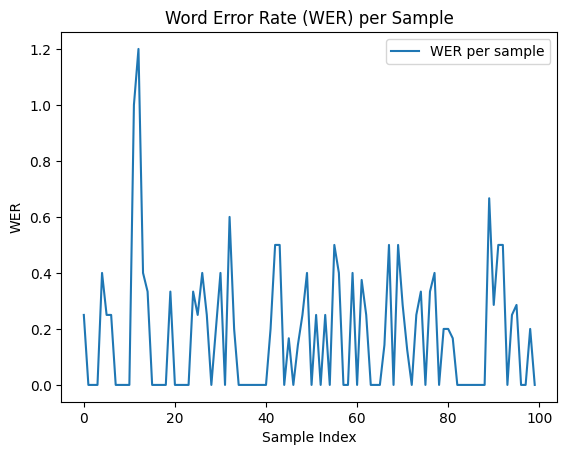

In [12]:
plt.plot(wers, label='WER per sample')
plt.xlabel('Sample Index')
plt.ylabel('WER')
plt.title('Word Error Rate (WER) per Sample')
plt.legend()
plt.show()

### Interpretation and Considerations:
* The average Word Error Rate (WER) across all samples is approximately **0.178**, meaning that about **17.8%** of the words in each transcription were incorrect, substituted, deleted, or extra.
* A **17.8%** error rate is acceptable for general applications, such as generating video subtitles.
* Improving accuracy involves collecting more training data and adjusting model parameters.